### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


TOP 50 DESASTRES COMENTADOS EN LOS TWEETS

In [8]:
desastres = tweets.groupby("keyword").agg({"target":["count","mean"]}).copy()
level0 = desastres.columns.get_level_values(0)
level1 = desastres.columns.get_level_values(1)
desastres.columns = level0 + "_" + level1
desastres.sort_values(by="target_count",ascending = False,inplace = True)
desastres = desastres.head(50) #TOP 50

[]

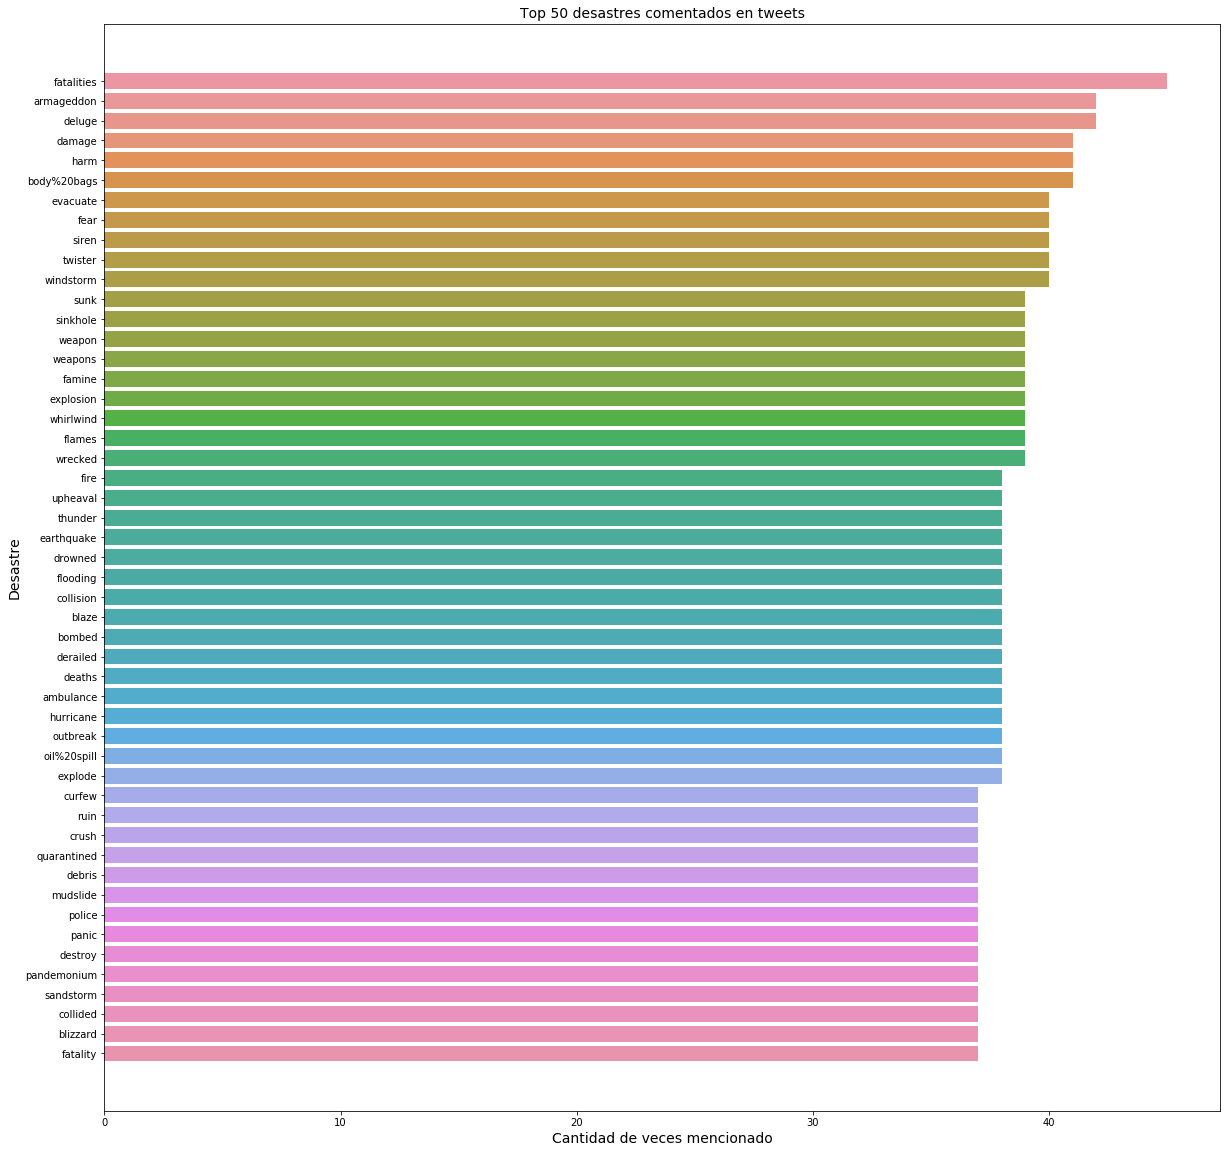

In [9]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = desastres,x = "target_count",y = desastres.index)
grafico.set_title("Top 50 desastres comentados en tweets",fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado",fontsize = 14)
grafico.set_ylabel("Desastre",fontsize = 14)
grafico.plot()

In [10]:
#
tweets['hashtags'] = tweets['text'].str.findall(r'#.*?(?=\s|$)')
tweets_hashtags = tweets.explode('hashtags')
tweets_hashtags.head(25)


,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,#Alaska
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,#wildfires
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#RockyFire
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#CAfire
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#wildfires
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood


In [11]:
hashtags = tweets_hashtags.groupby('hashtags').agg({'target':['count','mean']})
hashtags.sort_values(by=("target","count"),ascending = False,inplace = True)
hashtags[("target","mean")] = (hashtags[("target","mean")]*100).round()
hashtags = hashtags.head(50).reset_index()
hashtags.head(5)

hashtags target      
              count  mean
0      #News     37  86.0
1      #news     36  58.0
2      #best     30  43.0
3  #prebreak     30  43.0
4       #hot     30  43.0

/home/agustin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/agustin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


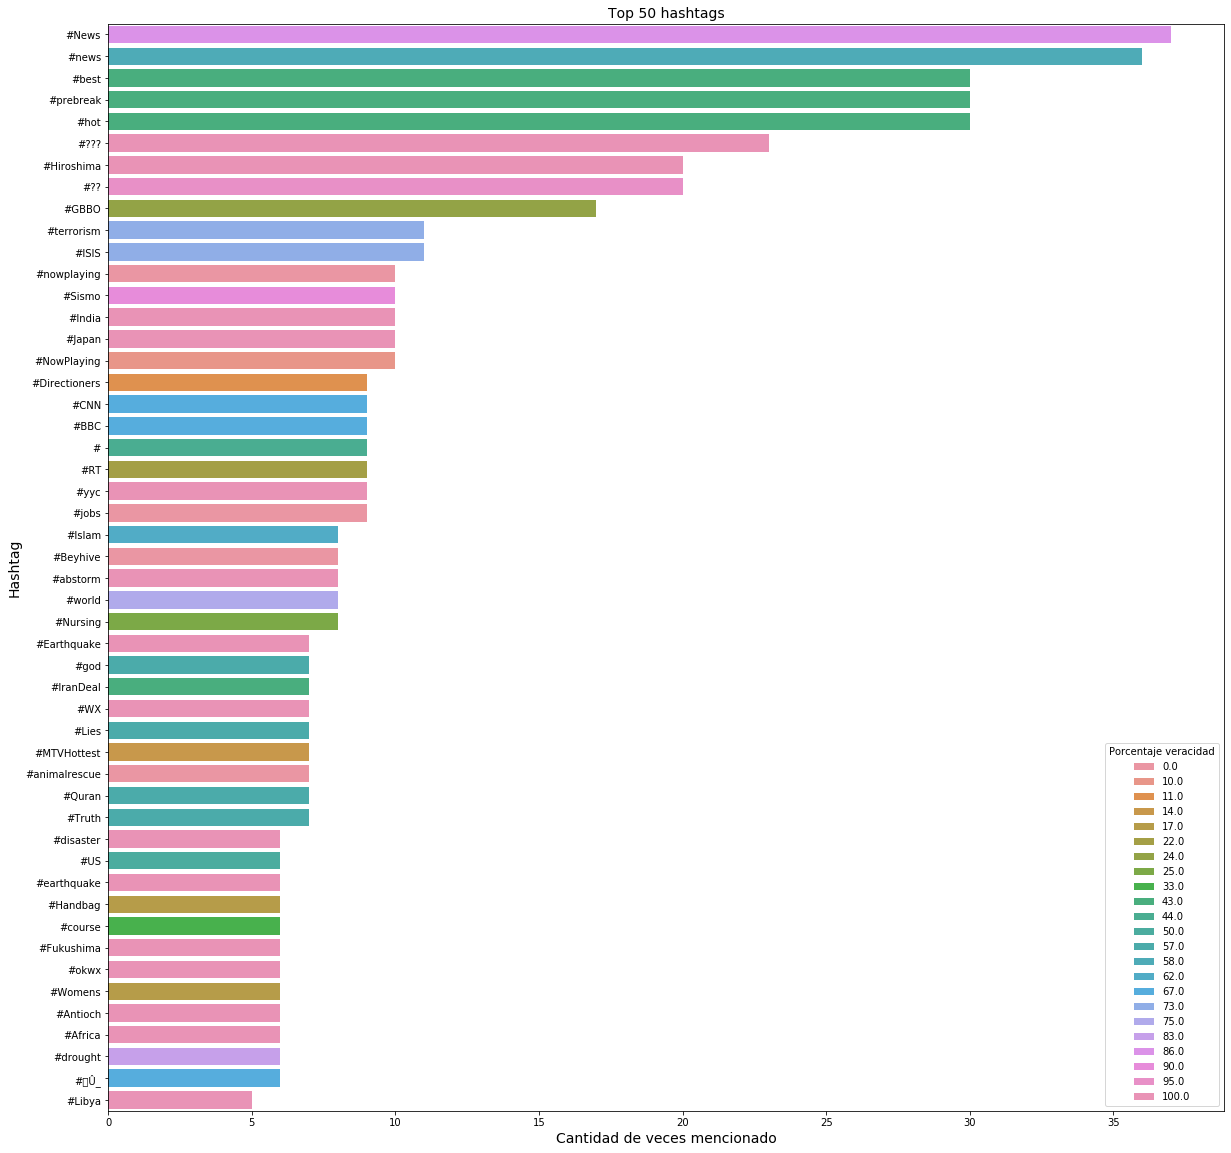

In [42]:

fig = plt.figure(figsize = (20, 20))
palette = sns.dark_palette("muted purple", input="xkcd")
grafico = sns.barplot(data = hashtags, x = ("target","count"), y = 'hashtags', hue = ('target','mean'), dodge = False)#, hue = ('target','mean'), palette = palette, dodge = False
grafico.set_title("Top 50 hashtags", fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado", fontsize = 14)
grafico.set_ylabel("Hashtag", fontsize = 14)
plt.legend(title='Porcentaje veracidad', loc='lower right')
plt.show(grafico)

In [44]:
tweets_locations = tweets[tweets['text'].str.contains(str(tweets['location']))]
tweets_locations

,id,keyword,location,text,target,hashtags


In [45]:
tweets.groupby('keyword').size().nlargest(20)

keyword
collision              35
whirlwind              33
armageddon             32
fatalities             32
derailed               31
emergency%20plan       31
flames                 31
outbreak               31
sandstorm              31
damage                 30
danger                 30
desolation             30
harm                   30
inundated              30
upheaval               30
airplane%20accident    29
deluge                 29
earthquake             29
flattened              29
flood                  29
dtype: int64

In [28]:
#Falta filtrar por target
tweets.dropna(subset = ['location', 'keyword'], inplace= True)
locations = tweets.groupby(['location', 'keyword']).size().nlargest(50)
locations = locations.reset_index()
col_rename = {0 : 'keyword_count'}
locations = locations.rename(columns = col_rename)
locations.drop_duplicates(subset = 'location',keep = 'first', inplace = True)
locations

,location,keyword,keyword_count
0,USA,sandstorm,17
1,Kenya,loud%20bang,16
2,New York,flood,13
4,ss,arsonist,10
5,304,aftershock,9
6,Mumbai,wreckage,9
8,Road to the Billionaires Club,derail,6
9,Everywhere,crush,5
10,India,derailment,5
11,"Washington, DC",derailed,5


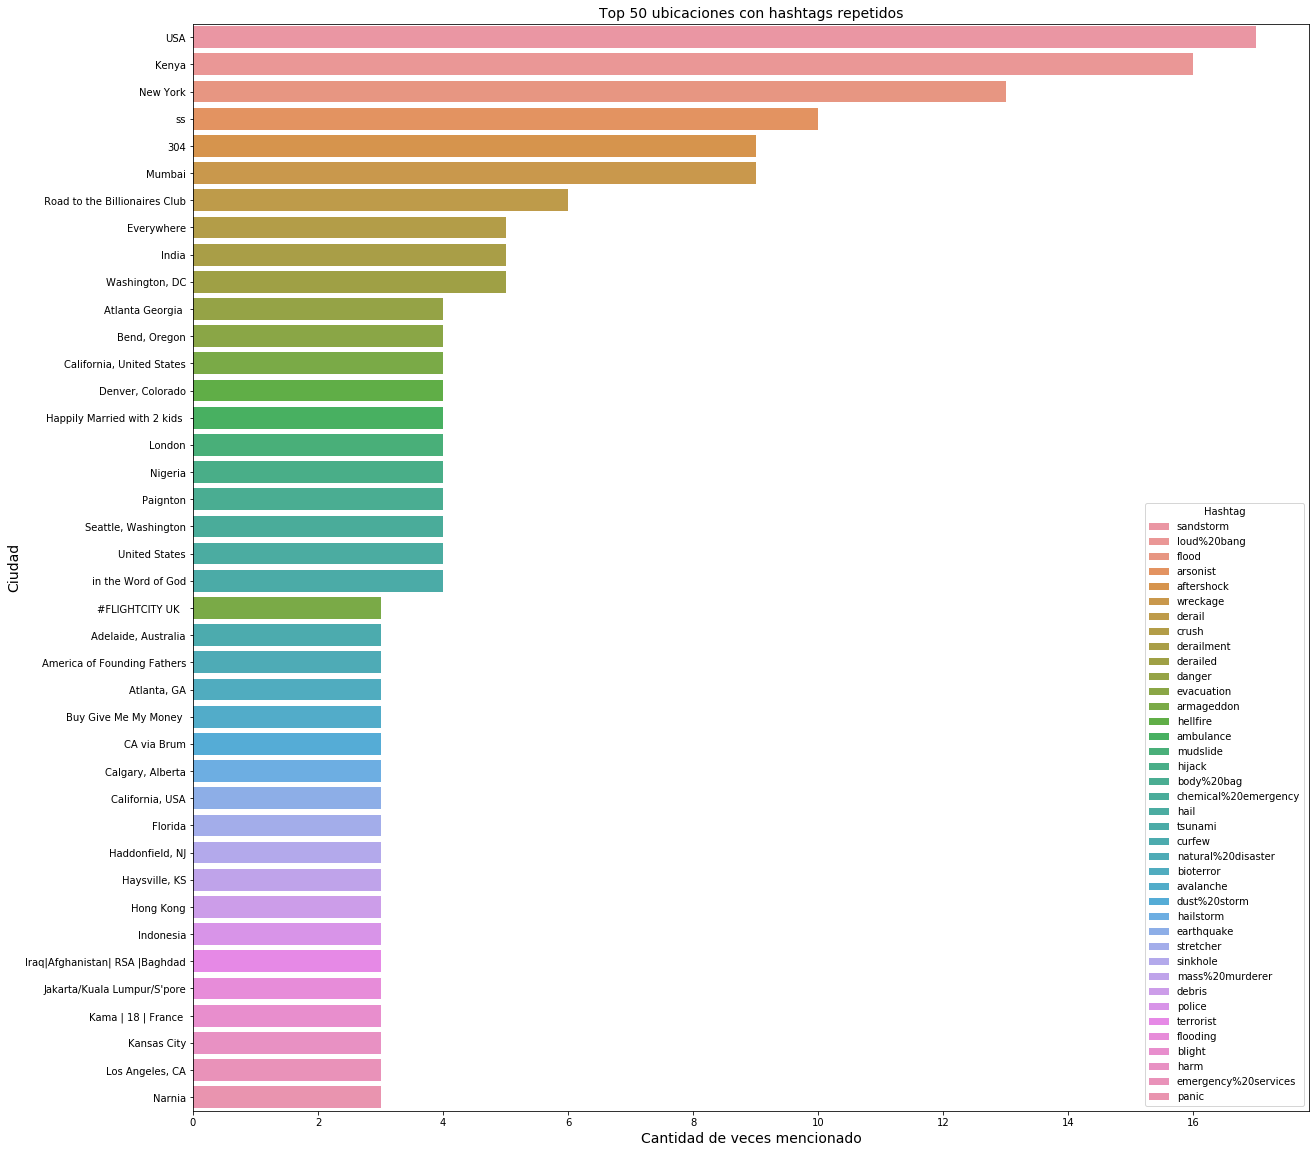

In [43]:
fig = plt.figure(figsize = (20, 20))
#palette = sns.dark_palette("muted purple", input="xkcd")
grafico = sns.barplot(data = locations, x = 'keyword_count', y = 'location', hue = 'keyword', dodge = False)#, hue = ('target','mean'), palette = palette, dodge = False
grafico.set_title("Top 50 ubicaciones con hashtags repetidos", fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado", fontsize = 14)
grafico.set_ylabel("Ciudad", fontsize = 14)
plt.legend(title='Hashtag', loc='lower right')
plt.show(grafico)